# SOC Direct Match Title File

Author: `pascal@bayesimpact.org`

Date: 2020-06-19

The US Bureau of Labor Statistics (BLS) is the maintainer of the [SOC](https://www.bls.gov/soc/), Standard Occupational Classification, which is the main job name classification taxonomy in the US (used by [O*net](./onet_overview.ipynb)). They also publish a specific file to match job titles to SOC as opposed as O*net where those are only there as alternate names. This notebook tries to make sense of this DMTFile in order to create a job suggest index.

To build a job suggest index, we are looking for a list of job titles commonly employed to refer to a job (e.g. "Farmer" not "Farmers, Ranchers and others"). For each job title, we want to have a job group and its ID (here a SOC ID). If possible we'd also want to have a possible comparison between those job titles to promote the ones that are most used (e.g. when typing "Data" we would want "Data Scientist" to pop up before an obscure "Naval Tactical Data System--Combat Information Center Watch Officer, General").

On their website the BLS publish the file as an XLS spreadsheet. You can download it in Bob with:

```sh
make data/usa/soc/DMTF.xlsx
```

Let's first import it and open it:

In [1]:
from os import path

import pandas as pd
import seaborn as sns

DATA_FOLDER = %env DATA_FOLDER
sns.set()

dmtf = pd.read_excel(path.join(DATA_FOLDER, 'usa/soc/DMTF.xlsx'))
dmtf.head(10)

,U.S. Bureau of Labor Statistics,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,On behalf of the Office of Management and Budg...,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,"November 2017 (Updated April 15, 2020)",NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,***Questions should be emailed to soc@bls.gov***,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,2018 SOC Code,2018 SOC Title,2018 SOC Direct Match Title,Illustrative Example
7,11-1011,Chief Executives,Admiral,x
8,11-1011,Chief Executives,CEO,NaN
9,11-1011,Chief Executives,Chief Executive Officer,NaN


Ooops, it looks like there are some documentation at the top, so we're going to skip the first rows:

In [2]:
dmtf = pd.read_excel(path.join(DATA_FOLDER, 'usa/soc/DMTF.xlsx'), skiprows=7)
dmtf.head()

,2018 SOC Code,2018 SOC Title,2018 SOC Direct Match Title,Illustrative Example
0,11-1011,Chief Executives,Admiral,x
1,11-1011,Chief Executives,CEO,NaN
2,11-1011,Chief Executives,Chief Executive Officer,NaN
3,11-1011,Chief Executives,Chief Financial Officer,x
4,11-1011,Chief Executives,Chief Operating Officer,x


Alright, much better!

The format seems pretty obvious from there. We're going to check that the SOC code and title are always consistant:

In [3]:
dmtf.drop_duplicates(['2018 SOC Code', '2018 SOC Title'])\
    .groupby('2018 SOC Code').size().value_counts().to_frame()

,0
1,864


Good: there are 864 SOC codes, and for each of them there is only one title. Everything seems normal.

Let's now check whether direct match titles are unique:

In [4]:
dmtf.groupby('2018 SOC Direct Match Title').size().value_counts().to_frame()

,0
1,6520


Pretty neat: each title is uniquely matched to one SOC code.

Finally let's look into those titles. We could print the number of titles per SOC code:

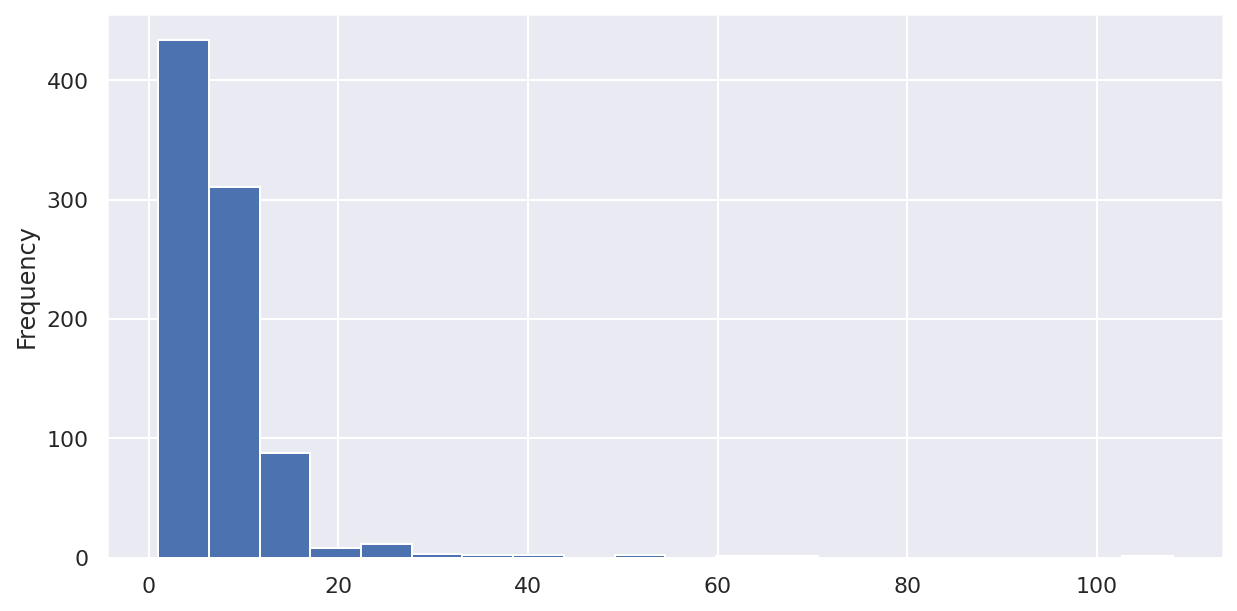

In [5]:
dmtf.groupby('2018 SOC Code').size().plot(kind='hist', figsize=(10, 5), bins=20);

Most SOC code (job groups) have less than 10 different titles, however it seems that few of them have more than 100:

In [6]:
dmtf.groupby('2018 SOC Title').size().sort_values(ascending=False).to_frame().head()

,0
2018 SOC Title,
"Military Officer Special and Tactical Operations Leaders, All Other",108
Command and Control Center Officers,70
"Military Enlisted Tactical Operations and Air/Weapons Specialists and Crew Members, All Other",63
Artillery and Missile Crew Members,53
Air Crew Members,51


It seems military have a lot of titles, let's check the first SOC group:

In [7]:
dmtf[dmtf['2018 SOC Title'] == 'Military Officer Special and Tactical Operations Leaders, All Other'].head(10)

,2018 SOC Code,2018 SOC Title,2018 SOC Direct Match Title,Illustrative Example
6095,55-1019,Military Officer Special and Tactical Operatio...,Advanced Foreign Counterintelligence Officer (...,NaN
6096,55-1019,Military Officer Special and Tactical Operatio...,Advanced Military Source Operations Officer (A...,NaN
6097,55-1019,Military Officer Special and Tactical Operatio...,Air Antisubmarine Officer,NaN
6098,55-1019,Military Officer Special and Tactical Operatio...,Air Boatswain,NaN
6099,55-1019,Military Officer Special and Tactical Operatio...,Air Intelligence Officer,NaN
6100,55-1019,Military Officer Special and Tactical Operatio...,All Source Intelligence,NaN
6101,55-1019,Military Officer Special and Tactical Operatio...,All Source Intelligence Technician,NaN
6102,55-1019,Military Officer Special and Tactical Operatio...,Amphibious Operations Officer,NaN
6103,55-1019,Military Officer Special and Tactical Operatio...,Antisubmarine Warfare Intelligence Officer,NaN
6104,55-1019,Military Officer Special and Tactical Operatio...,Antisubmarine Weapons Officer,NaN


OK, it seems that the army really cares about title, or at least that they were able to promote many different titles into the SOC somehow.

## Conclusion

The Direct Match Title File of SOC gives a pretty easy way to create a job suggest that would encompass more than 6k job names (or job titles) and for each of them a SOC code. However it does not have any numerical information that would help prefer most common job titles over rarely used ones.